## Creating pyspark session and loading dataset

In [1]:
# Importing necessary libraries
import findspark
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, sum
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql import SparkSession

# Initializing PySpark
findspark.init('C:/Users/rajat/OneDrive/Desktop/Big Data/spark-3.5.0-bin-hadoop3')

# Creating a PySpark session
spark = SparkSession.builder.appName("StockMarketAnalysis").getOrCreate()


In [2]:
# Read the CSV file into a PySpark DataFrame
spark_df = spark.read.csv("fh_5yrs.csv", header=True, inferSchema=True)

# Show the content of the PySpark DataFrame
spark_df.show()

+----------+------+------------------+------------------+------------------+------------------+------------------+------+
|      date|volume|              open|              high|               low|             close|          adjclose|symbol|
+----------+------+------------------+------------------+------------------+------------------+------------------+------+
|2020-07-02|257500|17.639999389648438|17.739999771118164|  17.6200008392334|17.709999084472656|17.709999084472656|  AAAU|
|2020-07-01|468100|17.729999542236328|17.729999542236328|17.540000915527347| 17.68000030517578| 17.68000030517578|  AAAU|
|2020-06-30|319100|17.649999618530273|17.799999237060547|17.610000610351562|17.780000686645508|17.780000686645508|  AAAU|
|2020-06-29|405500|17.670000076293945|17.690000534057614|  17.6299991607666| 17.68000030517578| 17.68000030517578|  AAAU|
|2020-06-26|335100|17.489999771118164|17.670000076293945|17.420000076293945|17.670000076293945|17.670000076293945|  AAAU|
|2020-06-25|246800|17.60

Date: Spanning from 2015 to 2020, the date column signifies the date of each transaction. 

Open: The opening price, denoting the initial transaction price per share after the market opening in USD.

High: Reflecting the highest transaction price during the trading date in USD. 

Low: Indicating the lowest transaction price for the trading date in USD.

Close: The closing price, representing the transaction price of the last trade during the trading date in USD.

Close Adjusted: The adjusted closing price for the trading date is the volume-weighted average price, including the last trade of all trades one minute before the last trade of the security on the same date. 

Volume: Representing the number of transactions between buyers and sellers of the stock on a given trading date. 

Symbol: Representing the unique identifier for a stock.


## Exploratory Data Analysis

In [3]:
#Number of rows
spark_df.count()

6852038

In [4]:
#Number of columns
len(spark_df.columns)

8

In [5]:
# Checking the range of dates
date_range = spark_df.agg(F.min("Date").alias("min_date"), F.max("Date").alias("max_date")).collect()[0]

# Displaying the date range
print(f"Data is available from {date_range['min_date']} to {date_range['max_date']}")

Data is available from 2015-01-02 to 2020-07-02


In [6]:
# Checking the count of total companies.
total_companies_count = spark_df.select("symbol").distinct().count()

# Displaying the count
print(f"Total number of unique companies: {total_companies_count}")


Total number of unique companies: 6335


In [7]:
# Count the number of missing values in each column
missing_values = spark_df.select([sum(col(column).isNull().cast("int")).alias(column) for column in spark_df.columns])

# Show the missing values counts
missing_values.show()

+----+------+----+----+---+-----+--------+------+
|date|volume|open|high|low|close|adjclose|symbol|
+----+------+----+----+---+-----+--------+------+
|   0|     0|   0|   0|  0|    0|       0|     0|
+----+------+----+----+---+-----+--------+------+



According to the above result, there is no missing value in the dataset

In [8]:
# Print the schema of the DataFrame
spark_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- volume: long (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- adjclose: double (nullable = true)
 |-- symbol: string (nullable = true)



In [9]:
# close and volume columns descriptive summary statistics
columns_to_analyze = ['close', 'volume']

# Display summary statistics for each specified column
for column_name in columns_to_analyze:
    column_stats = spark_df.select(column_name).summary()
    print(f"\nSummary Statistics for {column_name}:")
    column_stats.show()


Summary Statistics for close:
+-------+--------------------+
|summary|               close|
+-------+--------------------+
|  count|             6852038|
|   mean|   296.7830805422864|
| stddev|  115157.54666985657|
|    min|0.001000000047497451|
|    25%|    11.9399995803833|
|    50%|   24.94700050354004|
|    75%|    47.9000015258789|
|    max|         6.9513616E7|
+-------+--------------------+


Summary Statistics for volume:
+-------+------------------+
|summary|            volume|
+-------+------------------+
|  count|           6852038|
|   mean|1015413.7055740205|
| stddev| 4833379.770318016|
|    min|                 1|
|    25%|             18700|
|    50%|            120600|
|    75%|            586300|
|    max|        2156725200|
+-------+------------------+



## Exploring and Comparing  Tech Companies Stock

From all the dataset we are exploring the 3 tech companies stock dataset which are Apple, Facebook and Microsoft

In [10]:
# List of symbols for each tech company
tech_companies = ['AAPL', 'FB', 'MSFT']

# Combine all tech company symbols
all_symbols = tech_companies 

# Filter data for each industry
filtered_df = spark_df.filter(col('symbol').isin(all_symbols))

# Show the filtered data
filtered_df.show()

+----------+--------+------------------+------------------+------------------+------------------+------------------+------+
|      date|  volume|              open|              high|               low|             close|          adjclose|symbol|
+----------+--------+------------------+------------------+------------------+------------------+------------------+------+
|2020-07-02|28484300| 367.8500061035156| 370.4700012207031| 363.6400146484375| 364.1099853515625| 364.1099853515625|  AAPL|
|2020-07-01|27684300| 365.1199951171875| 367.3599853515625| 363.9100036621094| 364.1099853515625| 364.1099853515625|  AAPL|
|2020-06-30|35055800| 360.0799865722656| 365.9800109863281|             360.0| 364.7999877929688| 364.7999877929688|  AAPL|
|2020-06-29|32661500|            353.25| 362.1700134277344| 351.2799987792969| 361.7799987792969| 361.7799987792969|  AAPL|
|2020-06-26|51314200| 364.4100036621094| 365.3200073242188| 353.0199890136719| 353.6300048828125| 353.6300048828125|  AAPL|
|2020-06

## Time Series Analysis

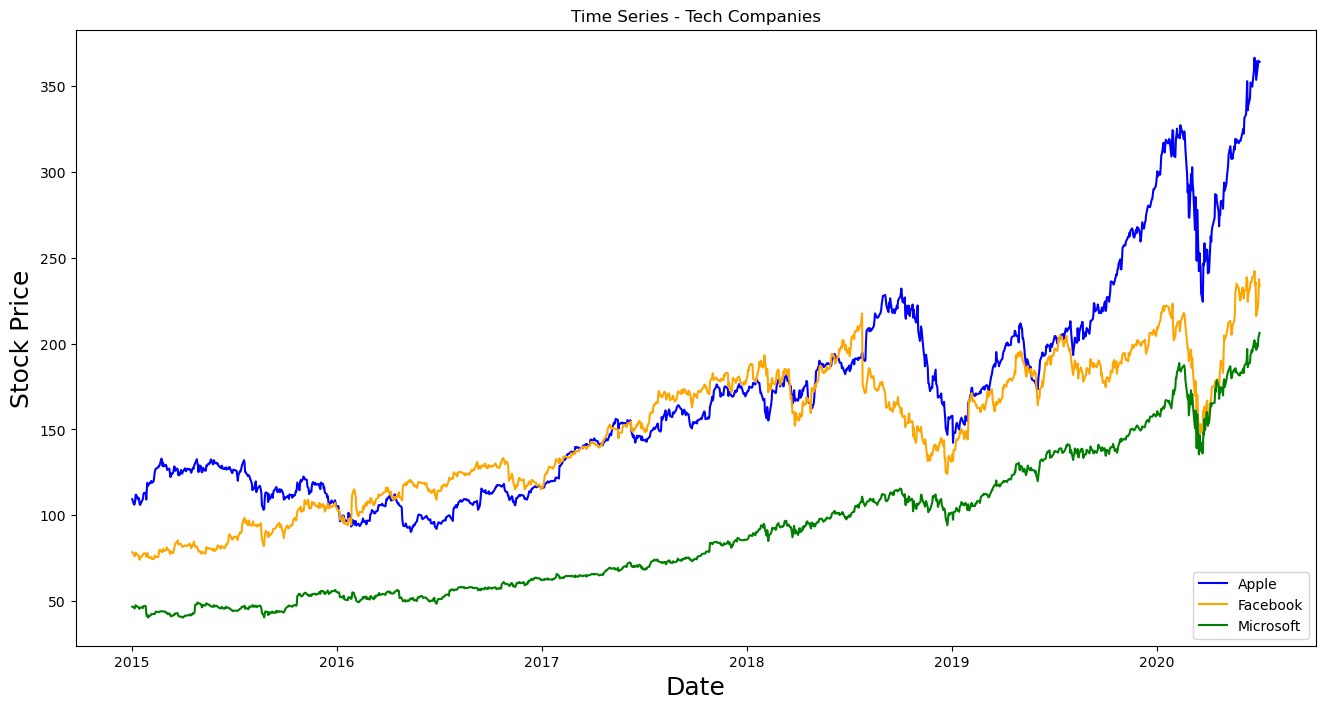

In [11]:
# Filter data for each company
apple_data = filtered_df.filter(filtered_df['symbol'] == 'AAPL').select('date', 'close').orderBy('date')
facebook_data = filtered_df.filter(filtered_df['symbol'] == 'FB').select('date', 'close').orderBy('date')
microsoft_data = filtered_df.filter(filtered_df['symbol'] == 'MSFT').select('date', 'close').orderBy('date')

# Convert PySpark DataFrames to Pandas DataFrames
apple_pd = apple_data.toPandas()
facebook_pd = facebook_data.toPandas()
microsoft_pd = microsoft_data.toPandas()

# Plot the data using Matplotlib
plt.figure(figsize=(16, 8))
plt.plot(apple_pd['date'], apple_pd['close'], color='blue')
plt.plot(facebook_pd['date'], facebook_pd['close'], color='orange')
plt.plot(microsoft_pd['date'], microsoft_pd['close'], color='green')
plt.title('Time Series - Tech Companies')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Stock Price', fontsize=18)
plt.legend(['Apple', 'Facebook', 'Microsoft'], loc='lower right')
plt.show()

According to the above graph, a clear trend emerges in the stock prices of Apple, Facebook, and Microsoft from 2015 to 2020. Initially, Apple exhibited a consistently high stock price, followed by Facebook and then Microsoft. Notably, in 2016, Facebook surpassed Apple, maintaining the top position until mid-2018. Although there were occasional dips below Apple, Facebook mostly remained above it. However, post-mid-2018, Facebook's stock declined relative to Apple. In mid-2019, it attempted a resurgence but faced a substantial downturn, touching Microsoft's stock levels in the early months of 2020. Subsequently, Apple's stock surged significantly, consistently securing the leading position, with Facebook in second place and Microsoft consistently trailing. Despite variations, all three companies experienced substantial stock growth from 2015 to 2020. Apple's stock, starting just above 100, reached an impressive 350 by the end. Similarly, Facebook, initially below 100, climbed to around 200, and Microsoft, starting near 50, reached approximately 150.

## Daily Return Analysis

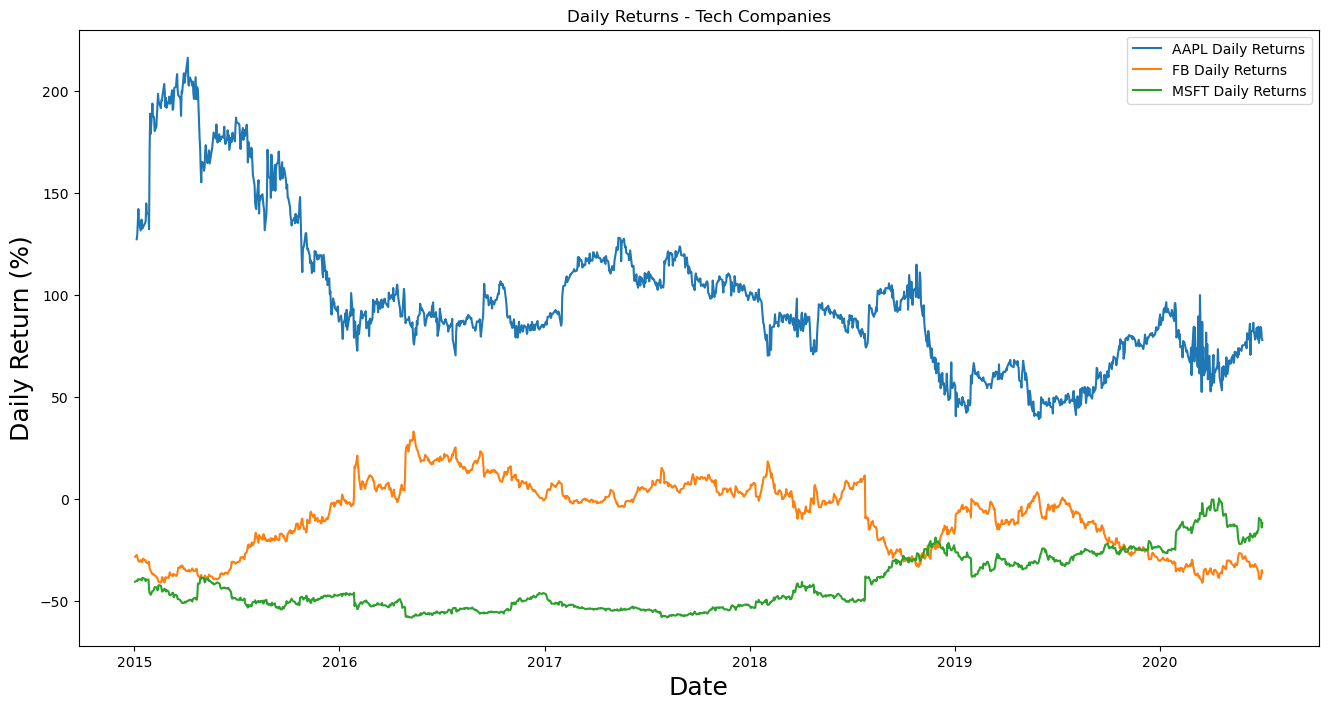

In [12]:
# List of tech company symbols
tech_company_symbols = ['AAPL', 'FB', 'MSFT']

# Filter data for tech companies
tech_data = filtered_df.filter(col('symbol').isin(tech_company_symbols)).orderBy('date')

# Create a Window specification
windowSpec = Window().orderBy('date')

# Calculate daily returns using lag function within the Window
tech_data = tech_data.withColumn('lag_close', F.lag('close').over(windowSpec))
tech_data = tech_data.withColumn('daily_return', (F.col('close') / F.col('lag_close') - 1) * 100)

# Convert PySpark DataFrame to Pandas DataFrame for easier plotting
tech_pd = tech_data.toPandas()

# Daily Returns
plt.figure(figsize=(16, 8))
for symbol in tech_company_symbols:
    symbol_data = tech_pd[tech_pd['symbol'] == symbol]
    plt.plot(symbol_data['date'], symbol_data['daily_return'], label=f'{symbol} Daily Returns')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Daily Return (%)', fontsize=18)
plt.title('Daily Returns - Tech Companies')
plt.legend()
plt.show()



From the above graph, it's evident that Apple's stock has consistently outperformed its competitors. Apple exhibited a remarkable daily return percentage, exceeding 150% in 2015, gradually declining over the years, with a drop to 100% observed towards the end of 2020. In contrast, both Facebook and Microsoft experienced negative daily return percentages. Although Facebook slightly achieved positive daily returns in 2016, it subsequently faced a downturn, falling below Microsoft in mid-2018 and maintaining the third position until the end of 2020. 


## Volume Change Analysis

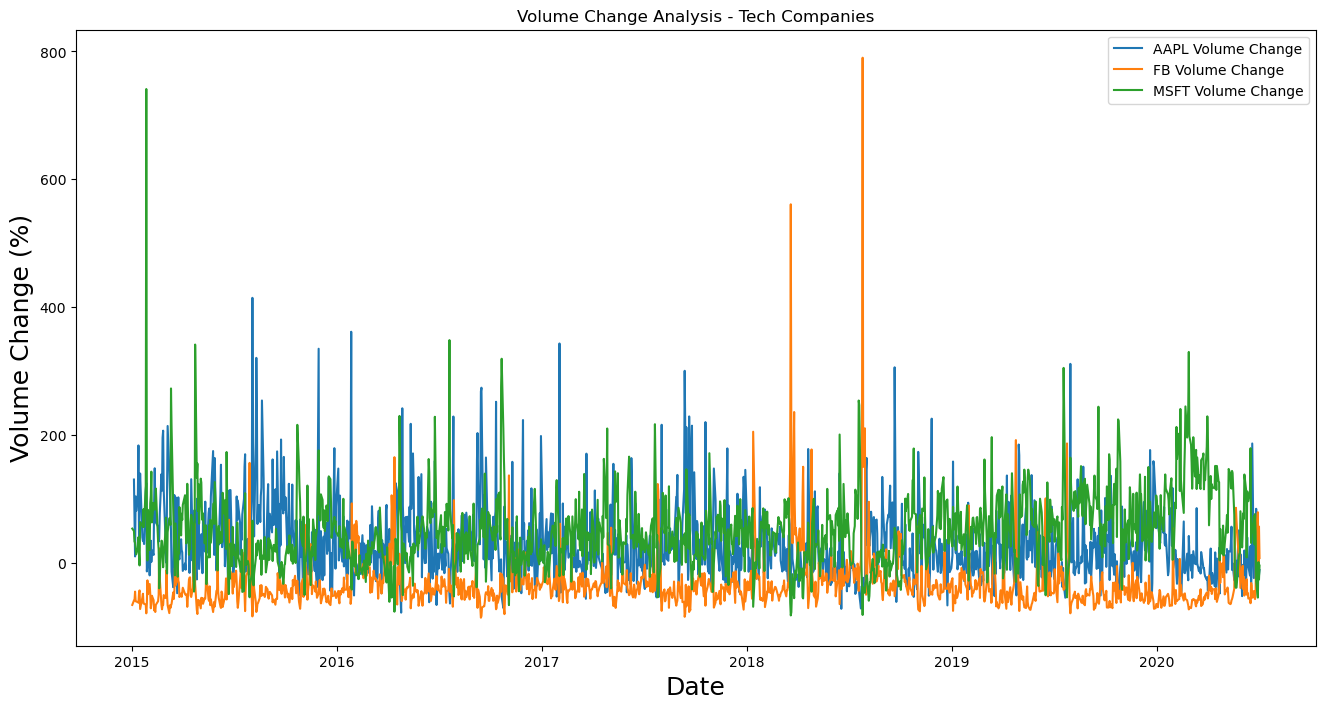

In [13]:
# List of tech company symbols
tech_company_symbols = ['AAPL', 'FB', 'MSFT']


# Filter data for tech companies
tech_data = filtered_df.filter(col('symbol').isin(tech_company_symbols)).orderBy('date')

# Create a Window specification
windowSpec = Window().orderBy('date')

# Calculate daily returns using lag function within the Window
tech_data = tech_data.withColumn('lag_volume', F.lag('volume').over(windowSpec))
tech_data = tech_data.withColumn('volume_change', (F.col('volume') / F.col('lag_volume') - 1) * 100)

# Convert PySpark DataFrame to Pandas DataFrame for easier plotting
tech_pd = tech_data.toPandas()


# Plot Volume Change for Each Tech Company
plt.figure(figsize=(16, 8))
for symbol in tech_company_symbols:
    symbol_data = tech_pd[tech_pd['symbol'] == symbol]
    plt.plot(symbol_data['date'], symbol_data['volume_change'], label=f'{symbol} Volume Change')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Volume Change (%)', fontsize=18)
plt.title('Volume Change Analysis - Tech Companies')
plt.legend()
plt.show()

In the displayed chart, it is evident that the percentage change in volume for Microsoft and Apple exhibits a generally consistent and high trend throughout the period spanning 2015 to 2020. On the other hand, Facebook's volume change percentage, while somewhat lower for the majority of the timeframe, experienced significant fluctuations, notably displaying a notable surge in mid-2018. Volume change percentage is a metric that reflects the relative increase or decrease in trading activity for a specific stock. Higher volume change percentages often indicate heightened market activity, potentially driven by significant events or shifts in investor sentiment. The observed patterns in volume change provide insights into the dynamics of market participation and the relative trading intensity for each company's stock.

## Candlestick Chart for Stock Prices

In [14]:
# Candlestick chart for stock prices
filtered_pd = filtered_df.toPandas()

import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=filtered_pd['date'],
                open=filtered_pd['open'],
                high=filtered_pd['high'],
                low=filtered_pd['low'],
                close=filtered_pd['close'])])
fig.update_layout(title='Candlestick Chart of Stock Prices',
                  xaxis_title='Date',
                  yaxis_title='Stock Price',
                  xaxis_rangeslider_visible=False)
fig.show()

In the displayed candlestick chart, the green lines represent an upward trend in the stock value for the respective day, indicating a positive movement. Conversely, the red lines signify a decrease, indicating a downward trend or a drop in the stock value. Candlestick charts provide a visual representation of daily price movements, with each candlestick encapsulating the opening, closing, high, and low prices for a specific trading day. The color coding, such as green for upward movements and red for downward movements, aids in easily interpreting the daily trends and price changes.


## Moving Averages

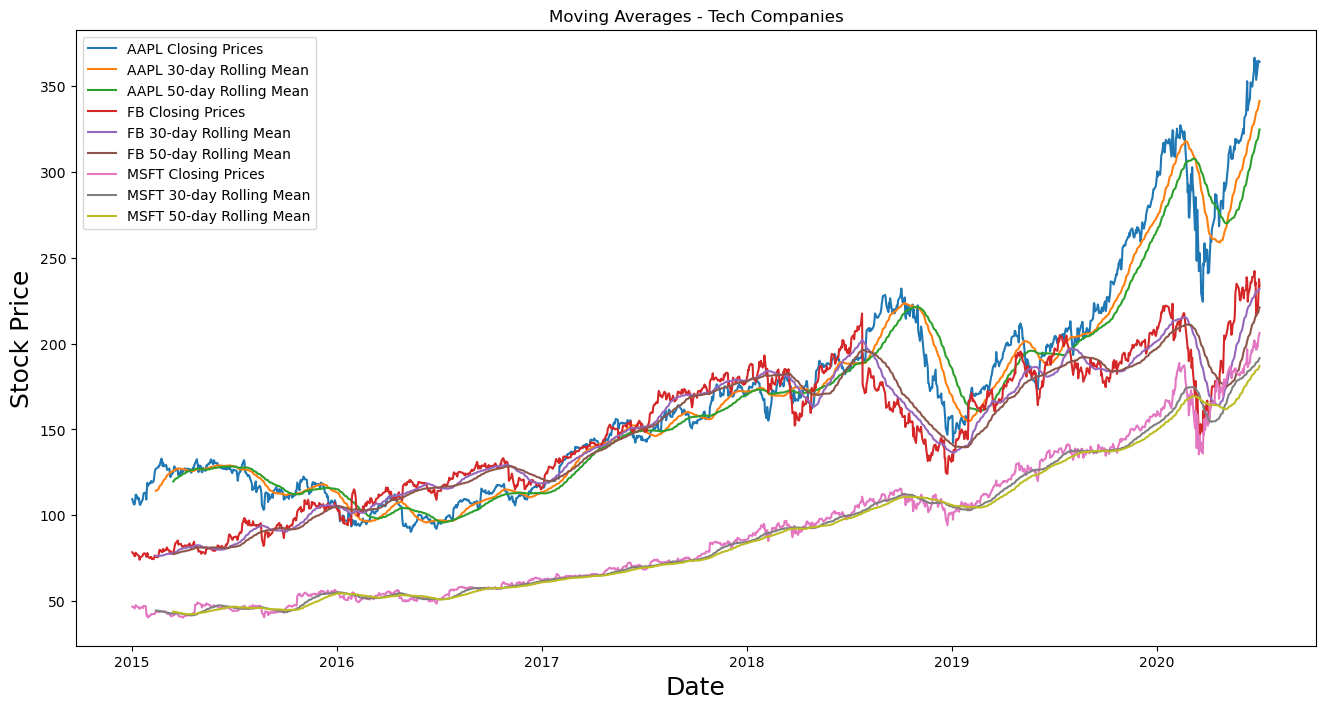

In [15]:
# 4. Moving Averages
plt.figure(figsize=(16, 8))
for symbol in tech_company_symbols:
    symbol_data = tech_pd[tech_pd['symbol'] == symbol].copy()  # Create a copy to avoid the SettingWithCopyWarning
    symbol_data['rolling_mean_30'] = symbol_data['close'].rolling(window=30).mean()
    symbol_data['rolling_mean_50'] = symbol_data['close'].rolling(window=50).mean()
    tech_pd.loc[tech_pd['symbol'] == symbol, 'rolling_mean_30'] = symbol_data['rolling_mean_30']
    tech_pd.loc[tech_pd['symbol'] == symbol, 'rolling_mean_50'] = symbol_data['rolling_mean_50']
    plt.plot(symbol_data['date'], symbol_data['close'], label=f'{symbol} Closing Prices')
    plt.plot(symbol_data['date'], symbol_data['rolling_mean_30'], label=f'{symbol} 30-day Rolling Mean')
    plt.plot(symbol_data['date'], symbol_data['rolling_mean_50'], label=f'{symbol} 50-day Rolling Mean')

plt.xlabel('Date', fontsize=18)
plt.ylabel('Stock Price', fontsize=18)
plt.title('Moving Averages - Tech Companies')
plt.legend()
plt.show()



Moving averages are statistical tools used in stock market analysis to smooth out price data and identify trends. In the context of the provided graphs, the closing prices of three tech companies (Apple, Facebook, Microsoft) are plotted alongside their 30-day and 50-day rolling averages. These moving averages help reduce short-term fluctuations, allowing analysts to discern overall trends more clearly. An upward-sloping moving average indicates an uptrend, while a downward slope suggests a downtrend. Moving averages also serve as dynamic support or resistance levels and are valuable for detecting potential trend reversals, especially when shorter-term averages cross above or below longer-term ones. Investors often use moving averages to inform trading decisions and assess the strength and direction of stock price movements.

## Correlation Analysis

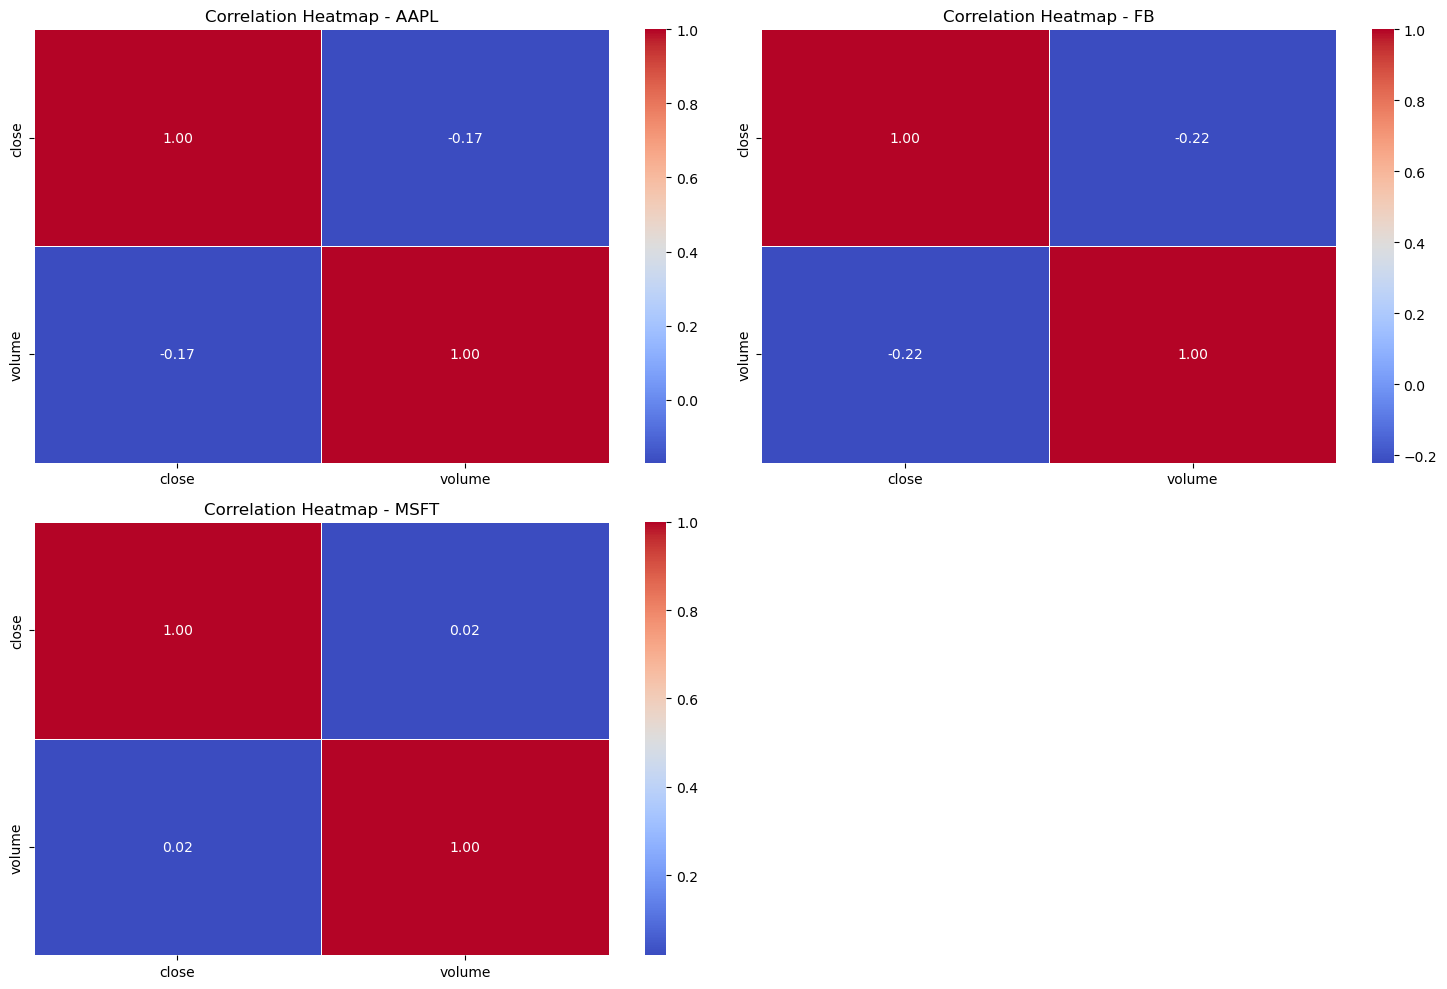

In [16]:
# List of tech company symbols
tech_company_symbols = ['AAPL', 'FB', 'MSFT']

# Create separate correlation matrices for each tech company
correlation_matrices = {}
for symbol in tech_company_symbols:
    symbol_data = tech_pd[tech_pd['symbol'] == symbol]
    correlation_matrix = symbol_data[['close','volume']].corr()
    correlation_matrices[symbol] = correlation_matrix

# Plot correlation heatmaps for each tech company
plt.figure(figsize=(15, 10))
for i, symbol in enumerate(tech_company_symbols, 1):
    plt.subplot(2, 2, i)
    sns.heatmap(correlation_matrices[symbol], annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Heatmap - {symbol}')
plt.tight_layout()
plt.show()


The positive correlation between volume and close price for Microsoft suggests a tendency for these two variables to move in the same direction. When the trading volume increases, there is a slight tendency for the close price of Microsoft stock to increase as well. On the other hand, the negative correlations for Apple and Facebook indicate an inverse relationship between volume and close price. In these cases, when the trading volume rises, the close prices for Apple and Facebook stocks tend to decrease, and vice versa. These correlations provide insights into how changes in trading activity may be associated with price movements, and they can be influenced by various factors, including market dynamics, investor sentiment, and external events affecting each company differently.

## Descriptive Analysis

In [17]:
#Descriptive Statistics
descriptive_stats_close = tech_pd.groupby('symbol')['close'].describe()
descriptive_stats_volume = tech_pd.groupby('symbol')['volume'].describe()

# Print Descriptive Statistics
print("Descriptive Statistics - Close Prices:")
print(descriptive_stats_close)

print("\nDescriptive Statistics - Volume:")
print(descriptive_stats_volume)


Descriptive Statistics - Close Prices:
         count        mean        std        min         25%         50%  \
symbol                                                                     
AAPL    1385.0  168.105018  60.888734  90.339996  117.120003  156.389999   
FB      1385.0  148.555177  40.957837  74.050003  115.080002  152.380005   
MSFT    1385.0   89.548022  40.843737  40.290001   54.400002   75.209999   

               75%         max  
symbol                          
AAPL    199.250000  366.529999  
FB      180.729996  242.240005  
MSFT    112.790001  206.259995  

Descriptive Statistics - Volume:
         count          mean           std         min         25%  \
symbol                                                               
AAPL    1385.0  3.653794e+07  1.807000e+07  11362000.0  24358400.0   
FB      1385.0  2.270165e+07  1.374705e+07   5913100.0  14407200.0   
MSFT    1385.0  3.046432e+07  1.513395e+07   7425600.0  21176300.0   

               50%         75%

Close Prices:

Apple has the highest average close price, followed by Facebook and Microsoft.

Apple has the highest volatility (standard deviation) in close prices.

All three companies experienced significant growth in their maximum close prices.

Volume:

Apple has the highest average volume of shares traded, followed by Microsoft and Facebook.

Apple has the highest volume volatility (standard deviation).

## RNN - LSTM Model

We are going to build RNN-LSTM model for apple dataset.

In [18]:
# For processing
import math
import random
import datetime as dt
import matplotlib.dates as mdates


# Libraries for model training
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [64]:
# Filtering apple dataset
apple_data = ['AAPL']
apple_spark = spark_df.filter(col('symbol').isin(apple_data))

# Show the filtered apple dataset
apple_spark.show()

+----------+--------+------------------+------------------+------------------+------------------+------------------+------+
|      date|  volume|              open|              high|               low|             close|          adjclose|symbol|
+----------+--------+------------------+------------------+------------------+------------------+------------------+------+
|2020-07-02|28484300| 367.8500061035156| 370.4700012207031| 363.6400146484375| 364.1099853515625| 364.1099853515625|  AAPL|
|2020-07-01|27684300| 365.1199951171875| 367.3599853515625| 363.9100036621094| 364.1099853515625| 364.1099853515625|  AAPL|
|2020-06-30|35055800| 360.0799865722656| 365.9800109863281|             360.0| 364.7999877929688| 364.7999877929688|  AAPL|
|2020-06-29|32661500|            353.25| 362.1700134277344| 351.2799987792969| 361.7799987792969| 361.7799987792969|  AAPL|
|2020-06-26|51314200| 364.4100036621094| 365.3200073242188| 353.0199890136719| 353.6300048828125| 353.6300048828125|  AAPL|
|2020-06

In [65]:
#Converting apple spark dataset to pandas
apple_df = apple_spark.toPandas()

In [66]:
#show apple dataframe
apple_df

date    volume        open        high         low       close  \
0     2020-07-02  28484300  367.850006  370.470001  363.640015  364.109985   
1     2020-07-01  27684300  365.119995  367.359985  363.910004  364.109985   
2     2020-06-30  35055800  360.079987  365.980011  360.000000  364.799988   
3     2020-06-29  32661500  353.250000  362.170013  351.279999  361.779999   
4     2020-06-26  51314200  364.410004  365.320007  353.019989  353.630005   
...          ...       ...         ...         ...         ...         ...   
1380  2015-01-08  59364500  109.230003  112.150002  108.699997  111.889999   
1381  2015-01-07  40105900  107.199997  108.199997  106.699997  107.750000   
1382  2015-01-06  65797100  106.540001  107.430000  104.629997  106.260002   
1383  2015-01-05  64285500  108.290001  108.650002  105.410004  106.250000   
1384  2015-01-02  53204600  111.389999  111.440002  107.349998  109.330002   

        adjclose symbol  
0     364.109985   AAPL  
1     364.109985   AAPL  
2     364.799988   AAPL  
3     361.779999   AAPL  
4     353.630005   AAPL  
...          ...    ...  
1380  102.286186   AAPL  
1381   98.501518   AAPL  
1382   97.139420   AAPL  
1383   97.130241   AAPL  
1384   99.945885   AAPL  

[1385 rows x 8 columns]

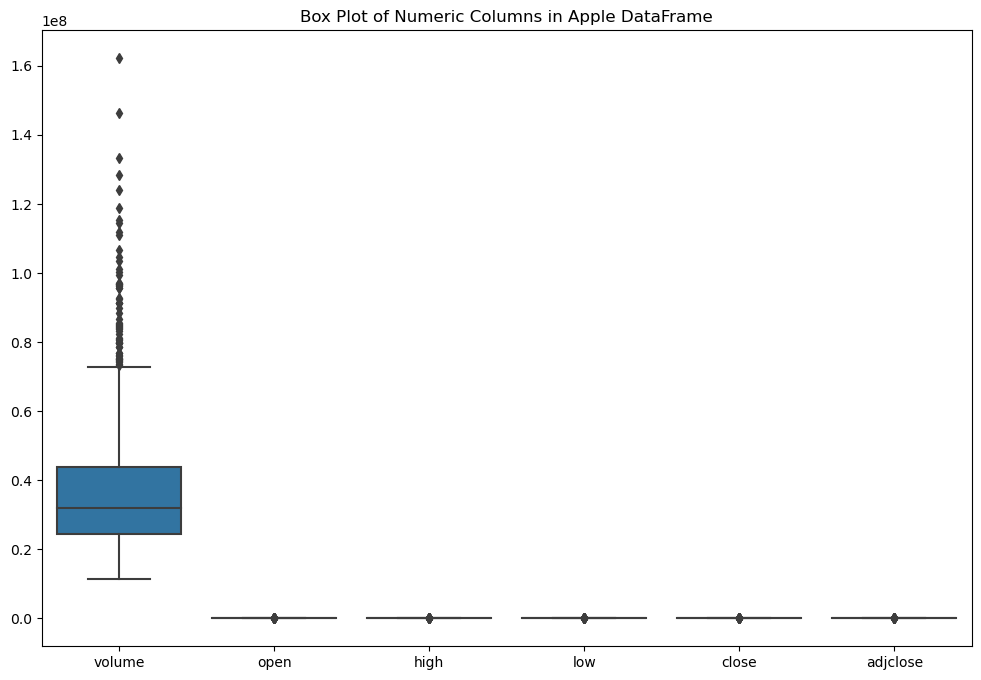

In [67]:
#Checking for outliers
numeric_columns = apple_df.select_dtypes(include=['float64', 'int64']).columns

# Create a box plot for each numeric column
plt.figure(figsize=(12, 8))
sns.boxplot(data=apple_df[numeric_columns])
plt.title('Box Plot of Numeric Columns in Apple DataFrame')
plt.show()

Based on the boxplot displayed above, it is evident that outliers are observed exclusively in the volume column. Since our modeling focus is on the close column, which does not exhibit outliers, we can proceed with building our model using the relevant data.

In [68]:
#Creating new data frame for building model with close values from apple dataframe.
new_df = apple_df.reset_index()['close']

In [69]:
# Normalizing our data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [70]:
scaled_data.shape

(1385, 1)

In [71]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

The scaled_data, which represents the normalized stock prices, is split into training and testing sets. The training set constitutes 80% of the data.

In [72]:
# Define the sequence length (number of past time steps)
n_past = 100

# Prepare sequences for LSTM
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Similarly prepare sequences for the test set
X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)


Sequences of data are created for the LSTM model. For each entry in the training set, it collects the previous n_past time steps (past stock prices) as input features (X_train) and the corresponding next time step as the target variable (y_train). This is done to create a supervised learning problem where the model learns to predict the next stock price based on a sequence of past prices.
Similar to the training set, sequences are prepared for the test set (X_test and y_test). This ensures that the model can be evaluated on unseen data.

In [73]:
print("Training set size:-")
print(X_train.shape), print(y_train.shape)
print("\n")
print("Testing set size:-")
print(X_test.shape), print(y_test.shape)

Training set size:-
(1008, 100)
(1008,)


Testing set size:-
(177, 100)
(177,)


(None, None)

In [74]:
# Reshape input data for LSTM([samples, time steps, features])
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

The input data (X_train and X_test) is reshaped to match the LSTM model's input shape, which expects a three-dimensional array in the form [samples, time steps, features]. In this context, samples are the number of sequences, time steps are the past data points considered, and features are the attributes used for prediction (in this case, just the closing stock price).

# Model Building

In [75]:
# Initialize a sequential model
model = Sequential()

# First LSTM layer with 100 units, input shape, and return sequences
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Adding dropout to prevent overfitting

# Second LSTM layer with 100 units and return sequences
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer with 100 units
model.add(LSTM(units=100))
model.add(Dropout(0.2))

# Add a dense output layer with one unit and use 'linear' activation for regression
model.add(Dense(units=1, activation='linear'))

# Compiling the model with Mean Squared Error loss and Adam optimizer with a lower learning rate
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 100)          40800     
                                                                 
 dropout_6 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_7 (LSTM)               (None, 100, 100)          80400     
                                                                 
 dropout_7 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                

This code sets up the architecture for an LSTM (Long Short-Term Memory) neural network model for stock price prediction using the Keras library. 
In Keras, the sequential model represents a linear stack of layers, where you can simply add one layer at a time. 
The LSTM layer is a type of recurrent neural network (RNN) layer designed to capture temporal dependencies in sequential data. The units parameter sets the number of memory units (neurons) in the layer. The return_sequences=True indicates that the layer should return the full sequence of outputs, which is important when stacking multiple LSTM layers.
The Dropout layer is added to prevent overfitting. It randomly sets a fraction of input units to zero at each update during training, which helps prevent overfitting. Similar blocks of code add two more LSTM layers with dropout for the model. 
A dense layer with one unit is added, and 'linear' activation is used. Since this is a regression task (predicting a continuous value), a linear activation is appropriate. 
The loss parameter specifies the loss function to be minimized during training, and in this case, it is mean squared error, which is suitable for regression problems. The optimizer parameter sets the optimization algorithm, and 'adam' is a popular choice for its adaptive learning rates.
In summary, this code sets up a sequential LSTM model with dropout layers for stock price prediction and compiles it for training. The model is designed to take sequences of past stock prices as input and predict the next stock price.

In [77]:
# Training our lstm model
history = model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64,validation_split=0.1)

Epoch 1/50
16/16 [==============================] - 9s 249ms/step - loss: 0.0200 - mae: 0.1033 - val_loss: 0.0063 - val_mae: 0.0775
Epoch 2/50
16/16 [==============================] - 3s 179ms/step - loss: 0.0031 - mae: 0.0429 - val_loss: 3.0292e-04 - val_mae: 0.0133
Epoch 3/50
16/16 [==============================] - 3s 181ms/step - loss: 0.0017 - mae: 0.0298 - val_loss: 3.1900e-04 - val_mae: 0.0144
Epoch 4/50
16/16 [==============================] - 3s 178ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 3.2322e-04 - val_mae: 0.0135
Epoch 5/50
16/16 [==============================] - 3s 177ms/step - loss: 0.0014 - mae: 0.0273 - val_loss: 3.3595e-04 - val_mae: 0.0150
Epoch 6/50
16/16 [==============================] - 3s 180ms/step - loss: 0.0014 - mae: 0.0274 - val_loss: 2.5809e-04 - val_mae: 0.0127
Epoch 7/50
16/16 [==============================] - 3s 184ms/step - loss: 0.0013 - mae: 0.0259 - val_loss: 2.5450e-04 - val_mae: 0.0123
Epoch 8/50
16/16 [==============================] - 

validation_data=(X_test, y_test): The validation dataset, which is used to evaluate the model's performance on data it hasn't seen during training.

epochs=50: The number of times the entire training dataset is passed forward and backward through the neural network. In this case, the training process will iterate 50 times over the entire dataset.

batch_size=64: The number of samples processed before the model is updated. It is a hyperparameter that influences the convergence of the model during training.

validation_split=0.1: It specifies the fraction of the training data to be used as validation data during training. In this case, 10% of the training data is used for validation.

During training, the model adjusts its weights based on the comparison between its predictions and the actual target values. 
The training process aims to minimize the mean squared error loss function. The history variable stores information about the training process, such as loss values and metrics, which can be used for later analysis or visualization.

This code essentially initiates the training of the LSTM model with the specified parameters, and the model learns to make predictions on stock prices as it iterates through the training data. The validation data help monitor the model's performance on unseen data to check for overfitting and assess generalization.

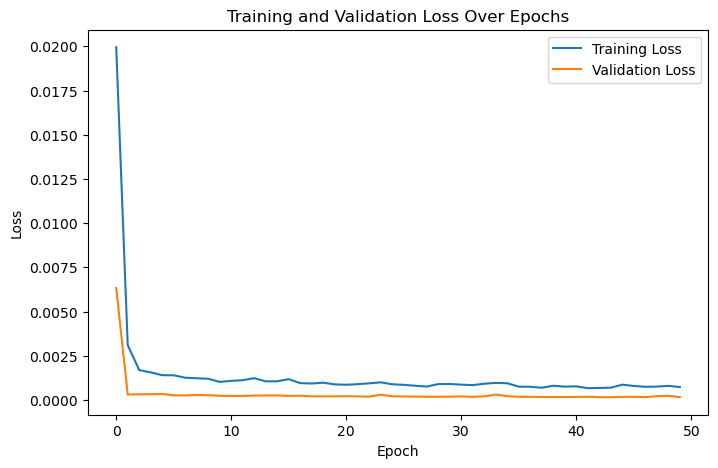

In [78]:
# Plot training loss and validation loss across epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing Model

In [79]:
# Let's do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

6/6 [==============================] - 0s 32ms/step


This code snippet performs predictions using the trained LSTM model on both the training set (X_train) and the test set (X_test). The predictions are obtained after the model has been trained on historical stock price data. These predictions represent the model's estimations of the stock prices corresponding to the input sequences. After obtaining these predictions, we can evaluate the model's performance by comparing these predicted values with the actual stock prices from the training and test sets. 

In [80]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

## Analyzing Result

In [81]:
# Calculate train data RMSE
print(math.sqrt(mean_squared_error(y_train,train_predict)))
# Calculate test data RMSE
print(math.sqrt(mean_squared_error(y_test,test_predict)))

5.801785298340106
3.4719850938128816


The RMSE for the training data is approximately 5.80. The RMSE for the test data is approximately 3.47. RMSE is a measure of the average deviation between predicted values and actual values. A lower RMSE indicates better model performance, as it signifies smaller prediction errors.


In [82]:
# Calculating Mean Absolute Percentage Error

from sklearn.metrics import mean_absolute_percentage_error

MAPE = mean_absolute_percentage_error(y_test, test_predict)
Accuracy = 1 - MAPE

print(MAPE)
print(Accuracy)

0.023054987171299536
0.9769450128287005


The MAPE is approximately 0.0230, indicating that, on average, the model's predictions have an absolute percentage error of about 2.30%. The accuracy is approximately 0.976, which means the model has an accuracy of around 97.6%. These metrics help assess the reliability of the LSTM model in predicting stock prices, with lower MAPE and higher accuracy values being desirable for better performance.

In [83]:
# Calculating R2 Score

from sklearn.metrics import r2_score

r2 = r2_score(y_test, test_predict)
print(f'R-squared: {r2}')

R-squared: 0.7821311936267414


The R-squared value is approximately 0.78, which is very close to 1.0. A high R-squared value indicates that the model explains a significant proportion of the variability in the actual stock prices, suggesting that the model's predictions align well with the observed data. In summary, the high R-squared score suggests that the LSTM model performs well in explaining and predicting the variation in stock prices based on the given features.


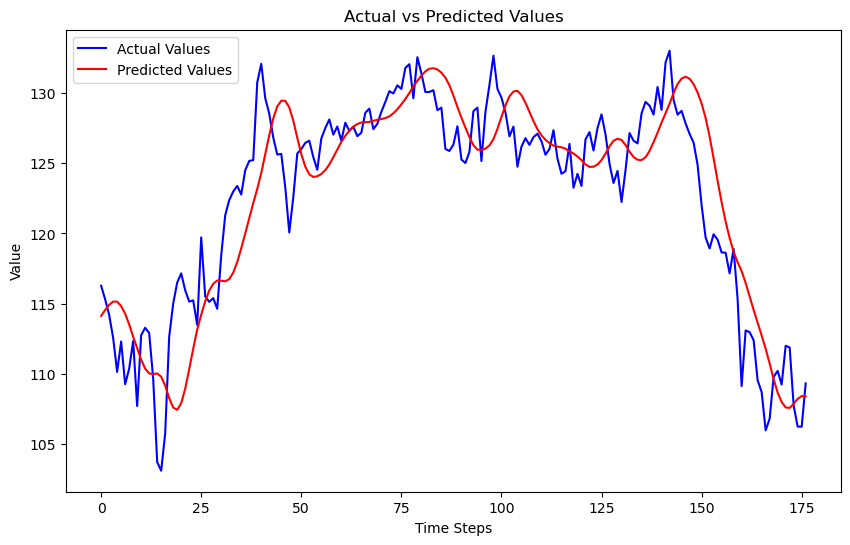

In [84]:
# Visualize the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='blue')
plt.plot(test_predict, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

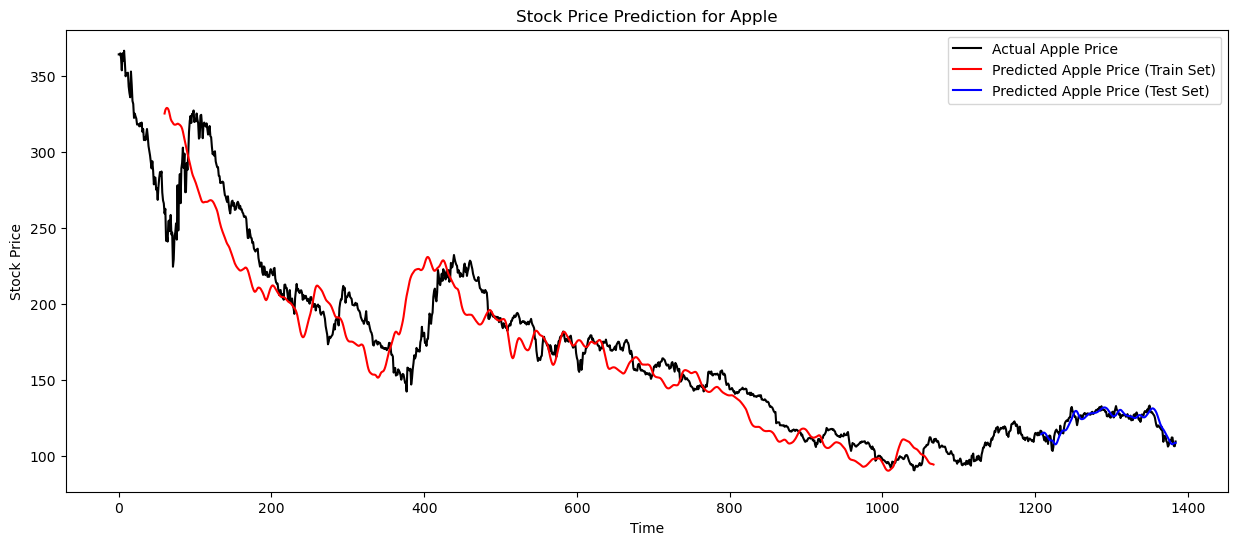

In [85]:
# Set the number of previous time steps to consider for plotting
look_back = 60

# Initialize an array for plotting the train predictions
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:] = np.nan
# Assign the predicted values to the appropriate location for train predictions
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict

# Initialize an array for plotting the test predictions
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:] = np.nan
# Calculate the starting index for the test predictions
test_start = len(scaled_data) - len(test_predict)
# Assign the predicted values to the appropriate location for test predictions
testPredictPlot[test_start:] = test_predict

# Rescale the scaled data back to its original scale using the scaler
original_scaled_data = scaler.inverse_transform(scaled_data)

# Plotting the baseline data, training predictions, and test predictions
plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label="Actual Apple Price")
plt.plot(trainPredictPlot, color='red', label="Predicted Apple Price (Train Set)")
plt.plot(testPredictPlot, color='blue', label="Predicted Apple Price (Test Set)")

plt.title("Stock Price Prediction for Apple")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()



According to the above visualization, we can clearly see the stock price prediction results for Apple. The training predictions are plotted in red, while the test predictions are plotted in blue, overlaid on the actual Apple stock prices shown in black. The result is a comprehensive visualization that allows for the comparison of predicted and actual stock prices over time, enabling an assessment of the model's performance in capturing the underlying patterns and trends in the stock price data. The plot provides a clear representation of how well the model aligns with the actual stock prices for both the training and test sets.

In [86]:
# To predict for the next 10 days, we'll need the last n_past days of data
last_sequence = X_test[-1]

# Reshape the last_sequence to match the input shape of the model
last_sequence = last_sequence.reshape(1, n_past, 1)

# Generate predictions for the next 10 days
predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction[0, 0])  # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
    last_sequence[0, -1, 0] = next_day_prediction  # Update the last element with the new prediction

# Transform the predictions back to the original scale
predictions_next_10_days = scaler.inverse_transform(np.array(predictions_next_10_days).reshape(-1, 1))

# Print the predictions for the next 10 days
print("Predictions for the next 10 days:")
for i, prediction in enumerate(predictions_next_10_days, start=1):
    print(f"Day {i}: Predicted Price = {prediction[0]}")

1/1 [==============================] - 0s 28ms/step
Predictions for the next 10 days:
Day 1: Predicted Price = 108.40413665771484
Day 2: Predicted Price = 108.2583999633789
Day 3: Predicted Price = 108.06744384765625
Day 4: Predicted Price = 107.8726806640625
Day 5: Predicted Price = 107.69215393066406
Day 6: Predicted Price = 107.52964782714844
Day 7: Predicted Price = 107.38188171386719
Day 8: Predicted Price = 107.24325561523438
Day 9: Predicted Price = 107.10838317871094
Day 10: Predicted Price = 106.97321319580078


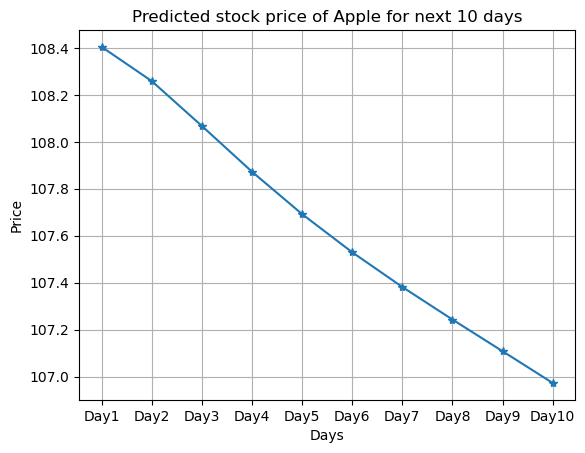

In [87]:
plt.plot(predictions_next_10_days, marker='*')
plt.title(f'Predicted stock price of Apple for next 10 days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.xticks(range(0, 10), ['Day1', 'Day2', 'Day3', 'Day4', 'Day5', 'Day6', 'Day7', 'Day8', 'Day9', 'Day10'])
plt.grid(True)
plt.show()

According to the above graph, we can predict the stock prices of Apple for the next 10 days using the LSTM model. 

In [88]:
# Stop the Spark session
spark.stop()